# Лабораторная работа №2: Логистическая и линейная регрессия

**Цель работы:** Изучить алгоритмы логистической и линейной регрессии и применить их для решения задач классификации и регрессии.


## Импорт библиотек


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve,
    mean_absolute_error, mean_squared_error, r2_score
)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## Загрузка данных


In [47]:
# Загружаем датасеты
stroke_data = pd.read_csv('../data/healthcare-dataset-stroke-data.csv')
insurance_data = pd.read_csv('../data/insurance.csv')

print("=" * 60)
print("ДАТАСЕТ ДЛЯ КЛАССИФИКАЦИИ (Stroke Prediction)")
print("=" * 60)
print(f"Размер: {stroke_data.shape}")
print(f"\nПервые строки:")
print(stroke_data.head())

print("\n" + "=" * 60)
print("ДАТАСЕТ ДЛЯ РЕГРЕССИИ (Insurance Cost)")
print("=" * 60)
print(f"Размер: {insurance_data.shape}")
print(f"\nПервые строки:")
print(insurance_data.head())


ДАТАСЕТ ДЛЯ КЛАССИФИКАЦИИ (Stroke Prediction)
Размер: (5110, 12)

Первые строки:
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  

## 2. Создание бейзлайна и оценка качества

### 2.a. Подготовка данных для обучения моделей из sklearn


In [48]:
# Предобработка датасета для классификации
stroke_df = stroke_data.copy()
stroke_df = stroke_df.drop('id', axis=1)
stroke_df['bmi'].fillna(stroke_df['bmi'].median(), inplace=True)

# Кодирование категориальных признаков
label_encoders = {}
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for col in categorical_columns:
    le = LabelEncoder()
    stroke_df[col] = le.fit_transform(stroke_df[col])
    label_encoders[col] = le

X_stroke = stroke_df.drop('stroke', axis=1)
y_stroke = stroke_df['stroke']

# Разделение на train/test
X_train_stroke, X_test_stroke, y_train_stroke, y_test_stroke = train_test_split(
    X_stroke, y_stroke, test_size=0.2, random_state=42, stratify=y_stroke
)

# Масштабирование
scaler_stroke = StandardScaler()
X_train_stroke_scaled = scaler_stroke.fit_transform(X_train_stroke)
X_test_stroke_scaled = scaler_stroke.transform(X_test_stroke)

print(f"Train: {X_train_stroke_scaled.shape}, Test: {X_test_stroke_scaled.shape}")


Train: (4088, 10), Test: (1022, 10)


In [49]:
# Предобработка датасета для регрессии
insurance_df = insurance_data.copy()

insurance_df['sex'] = insurance_df['sex'].map({'male': 0, 'female': 1})
insurance_df['smoker'] = insurance_df['smoker'].map({'no': 0, 'yes': 1})

le_region = LabelEncoder()
insurance_df['region'] = le_region.fit_transform(insurance_df['region'])

X_insurance = insurance_df.drop('charges', axis=1)
y_insurance = insurance_df['charges']

# Разделение на train/test
X_train_insurance, X_test_insurance, y_train_insurance, y_test_insurance = train_test_split(
    X_insurance, y_insurance, test_size=0.2, random_state=42
)

# Масштабирование
scaler_insurance = StandardScaler()
X_train_insurance_scaled = scaler_insurance.fit_transform(X_train_insurance)
X_test_insurance_scaled = scaler_insurance.transform(X_test_insurance)

print(f"Train: {X_train_insurance_scaled.shape}, Test: {X_test_insurance_scaled.shape}")


Train: (1070, 6), Test: (268, 6)


### 2.b. Обучение и оценка базовых моделей sklearn

#### Базовая модель: Логистическая регрессия для классификации


БАЗОВАЯ МОДЕЛЬ: ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ
Accuracy:  0.9511
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000
ROC-AUC:   0.8377


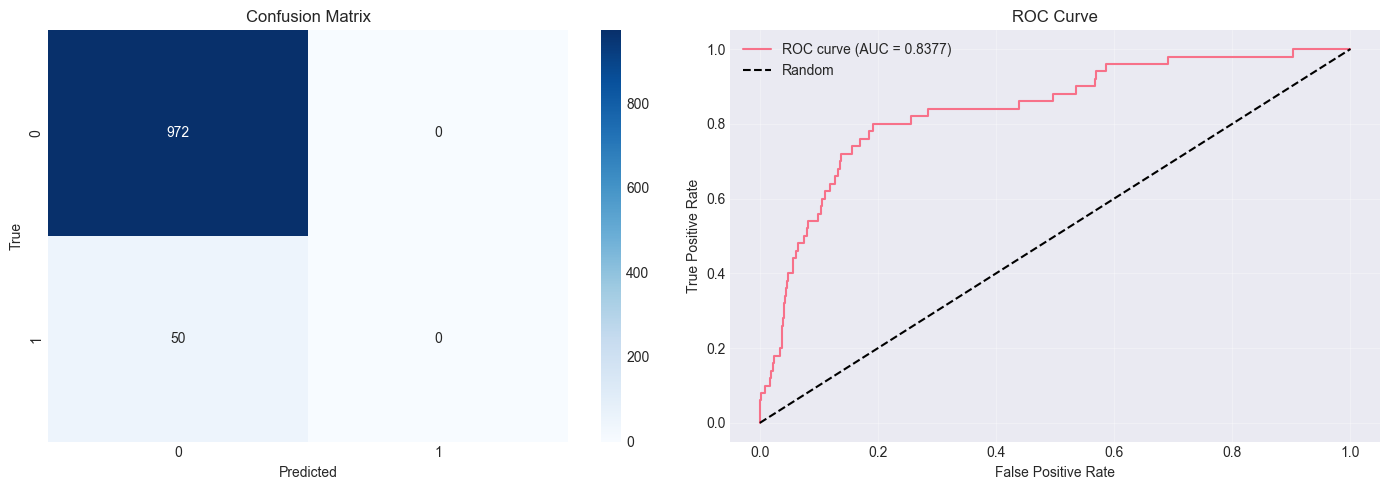


ТОП-5 НАИБОЛЕЕ ВАЖНЫХ ПРИЗНАКОВ (по абсолютному значению коэффициента):
             feature  coefficient  abs_coefficient
1                age     1.585086         1.585086
7  avg_glucose_level     0.180182         0.180182
2       hypertension     0.134778         0.134778
4       ever_married    -0.121328         0.121328
5          work_type    -0.067480         0.067480


In [50]:
# Обучаем базовую модель логистической регрессии
log_reg_base = LogisticRegression(random_state=42, max_iter=1000)
log_reg_base.fit(X_train_stroke_scaled, y_train_stroke)

# Предсказания
y_pred_stroke_base = log_reg_base.predict(X_test_stroke_scaled)
y_pred_proba_stroke_base = log_reg_base.predict_proba(X_test_stroke_scaled)[:, 1]

# Метрики
accuracy_base = accuracy_score(y_test_stroke, y_pred_stroke_base)
precision_base = precision_score(y_test_stroke, y_pred_stroke_base)
recall_base = recall_score(y_test_stroke, y_pred_stroke_base)
f1_base = f1_score(y_test_stroke, y_pred_stroke_base)
roc_auc_base = roc_auc_score(y_test_stroke, y_pred_proba_stroke_base)

print("=" * 60)
print("БАЗОВАЯ МОДЕЛЬ: ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ")
print("=" * 60)
print(f"Accuracy:  {accuracy_base:.4f}")
print(f"Precision: {precision_base:.4f}")
print(f"Recall:    {recall_base:.4f}")
print(f"F1-Score:  {f1_base:.4f}")
print(f"ROC-AUC:   {roc_auc_base:.4f}")

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm = confusion_matrix(y_test_stroke, y_pred_stroke_base)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_ylabel('True')
axes[0].set_xlabel('Predicted')

fpr, tpr, _ = roc_curve(y_test_stroke, y_pred_proba_stroke_base)
axes[1].plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_base:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Анализ коэффициентов
print("\n" + "=" * 60)
print("ТОП-5 НАИБОЛЕЕ ВАЖНЫХ ПРИЗНАКОВ (по абсолютному значению коэффициента):")
print("=" * 60)
feature_importance = pd.DataFrame({
    'feature': X_stroke.columns,
    'coefficient': log_reg_base.coef_[0]
})
feature_importance['abs_coefficient'] = np.abs(feature_importance['coefficient'])
feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)
print(feature_importance.head())


#### Базовая модель: Линейная регрессия


БАЗОВАЯ МОДЕЛЬ: ЛИНЕЙНАЯ РЕГРЕССИЯ
MAE:         $4,186.51
RMSE:        $5,799.59
R²:          0.7833
Adjusted R²: 0.7784


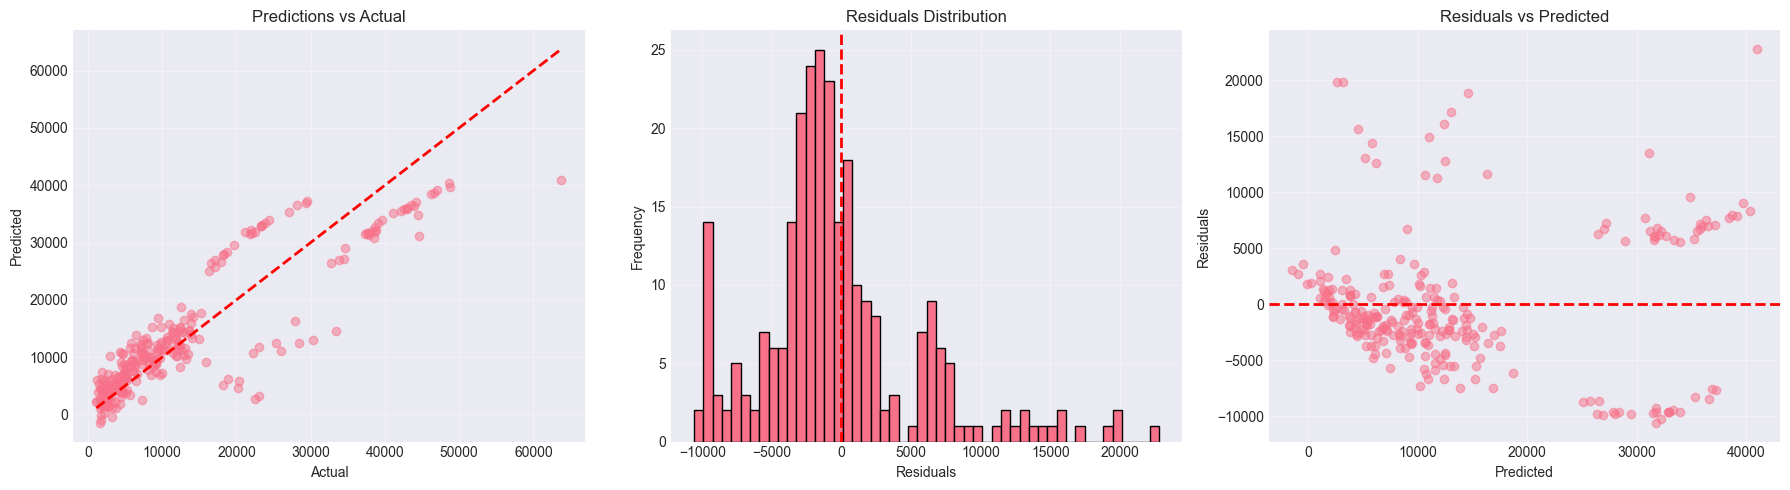


КОЭФФИЦИЕНТЫ РЕГРЕССИИ (отсортированы по абсолютному значению):
    feature  coefficient  abs_coefficient
4    smoker  9557.143383      9557.143383
0       age  3616.108652      3616.108652
2       bmi  2028.308579      2028.308579
3  children   516.662566       516.662566
5    region  -302.387980       302.387980
1       sex     9.392954         9.392954

Intercept (свободный член): 13346.09


In [51]:
# Обучаем базовую модель линейной регрессии
lin_reg_base = LinearRegression()
lin_reg_base.fit(X_train_insurance_scaled, y_train_insurance)

# Предсказания
y_pred_insurance_base = lin_reg_base.predict(X_test_insurance_scaled)

# Метрики
mae_base = mean_absolute_error(y_test_insurance, y_pred_insurance_base)
rmse_base = np.sqrt(mean_squared_error(y_test_insurance, y_pred_insurance_base))
r2_base = r2_score(y_test_insurance, y_pred_insurance_base)

# Adjusted R²
n = len(y_test_insurance)
p = X_test_insurance_scaled.shape[1]
adj_r2_base = 1 - (1 - r2_base) * (n - 1) / (n - p - 1)

print("=" * 60)
print("БАЗОВАЯ МОДЕЛЬ: ЛИНЕЙНАЯ РЕГРЕССИЯ")
print("=" * 60)
print(f"MAE:         ${mae_base:,.2f}")
print(f"RMSE:        ${rmse_base:,.2f}")
print(f"R²:          {r2_base:.4f}")
print(f"Adjusted R²: {adj_r2_base:.4f}")

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(y_test_insurance, y_pred_insurance_base, alpha=0.5)
axes[0].plot([y_test_insurance.min(), y_test_insurance.max()],
             [y_test_insurance.min(), y_test_insurance.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title('Predictions vs Actual')
axes[0].grid(True, alpha=0.3)

residuals = y_test_insurance - y_pred_insurance_base
axes[1].hist(residuals, bins=50, edgecolor='black')
axes[1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residuals Distribution')
axes[1].grid(True, alpha=0.3)

axes[2].scatter(y_pred_insurance_base, residuals, alpha=0.5)
axes[2].axhline(y=0, color='r', linestyle='--', lw=2)
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Residuals')
axes[2].set_title('Residuals vs Predicted')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("КОЭФФИЦИЕНТЫ РЕГРЕССИИ (отсортированы по абсолютному значению):")
print("=" * 60)
coefficients = pd.DataFrame({
    'feature': X_insurance.columns,
    'coefficient': lin_reg_base.coef_
})
coefficients['abs_coefficient'] = np.abs(coefficients['coefficient'])
coefficients = coefficients.sort_values('abs_coefficient', ascending=False)
print(coefficients)
print(f"\nIntercept (свободный член): {lin_reg_base.intercept_:.2f}")


## 3. Улучшение бейзлайна

### 3.a. Формулирование гипотез

**Гипотеза 1: Полиномиальные признаки**
- Линейные модели могут улавливать нелинейные зависимости через полиномиальные признаки
- Метод: Создадим полиномиальные признаки 2-й степени для ключевых переменных

**Гипотеза 2: Feature Engineering**
- Создание новых признаков на основе доменных знаний
- Классификация: возрастные группы, индекс здоровья
- Регрессия: взаимодействие возраста и курения, BMI категории

**Гипотеза 3: Регуляризация (Ridge/Lasso)**
- Базовая линейная регрессия может переобучаться
- Метод: Применим L1 (Lasso) и L2 (Ridge) регуляризацию

**Гипотеза 4: Обработка дисбаланса классов**
- Для классификации: настройка class_weight для учета дисбаланса
- Метод: Используем параметр class_weight='balanced'

**Гипотеза 5: Подбор гиперпараметров**
- Оптимальные параметры C (для логистической регрессии) и alpha (для Ridge/Lasso)
- Метод: GridSearchCV для подбора оптимальных значений


### 3.b. Проверка гипотез

#### Гипотеза 1: Полиномиальные признаки


In [52]:
# Создаем полиномиальные признаки для регрессии (степень 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_insurance_poly = poly.fit_transform(X_train_insurance_scaled)
X_test_insurance_poly = poly.transform(X_test_insurance_scaled)

print(f"Количество признаков до: {X_train_insurance_scaled.shape[1]}")
print(f"Количество признаков после: {X_train_insurance_poly.shape[1]}")

# Обучаем модель с полиномиальными признаками
lin_reg_poly = LinearRegression()
lin_reg_poly.fit(X_train_insurance_poly, y_train_insurance)

y_pred_poly = lin_reg_poly.predict(X_test_insurance_poly)

mae_poly = mean_absolute_error(y_test_insurance, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test_insurance, y_pred_poly))
r2_poly = r2_score(y_test_insurance, y_pred_poly)

print(f"\nРезультаты с полиномиальными признаками:")
print(f"MAE:  ${mae_poly:,.2f} (было ${mae_base:,.2f})")
print(f"RMSE: ${rmse_poly:,.2f} (было ${rmse_base:,.2f})")
print(f"R²:   {r2_poly:.4f} (было {r2_base:.4f})")


Количество признаков до: 6
Количество признаков после: 27

Результаты с полиномиальными признаками:
MAE:  $2,730.32 (было $4,186.51)
RMSE: $4,531.07 (было $5,799.59)
R²:   0.8678 (было 0.7833)


#### Гипотеза 2: Feature Engineering


In [53]:
# Feature Engineering для классификации
stroke_df_fe = stroke_df.copy()

stroke_df_fe['age_group'] = pd.cut(stroke_df_fe['age'], 
                                    bins=[0, 30, 50, 70, 100],
                                    labels=[0, 1, 2, 3]).astype(int)

stroke_df_fe['health_index'] = (
    (stroke_df_fe['hypertension'] * 2) +
    (stroke_df_fe['heart_disease'] * 3) +
    ((stroke_df_fe['avg_glucose_level'] > 140).astype(int) * 2) +
    ((stroke_df_fe['bmi'] > 30).astype(int))
)

stroke_df_fe['bmi_category'] = pd.cut(stroke_df_fe['bmi'],
                                       bins=[0, 18.5, 25, 30, 100],
                                       labels=[0, 1, 2, 3]).astype(int)

# Feature Engineering для регрессии
insurance_df_fe = insurance_df.copy()

insurance_df_fe['bmi_category'] = pd.cut(insurance_df_fe['bmi'],
                                          bins=[0, 18.5, 25, 30, 100],
                                          labels=[0, 1, 2, 3]).astype(int)

insurance_df_fe['age_smoker'] = insurance_df_fe['age'] * insurance_df_fe['smoker']

insurance_df_fe['risk_score'] = (
    (insurance_df_fe['age'] / 64) * 0.3 +
    (insurance_df_fe['smoker'] * 0.4) +
    (insurance_df_fe['bmi'] / 53) * 0.3
)

print(f"Новые признаки для классификации: age_group, health_index, bmi_category")
print(f"Новые признаки для регрессии: bmi_category, age_smoker, risk_score")


Новые признаки для классификации: age_group, health_index, bmi_category
Новые признаки для регрессии: bmi_category, age_smoker, risk_score


#### Гипотеза 3: Регуляризация (Ridge и Lasso)


СРАВНЕНИЕ РЕГУЛЯРИЗАЦИИ
Модель               MAE             RMSE            R²
------------------------------------------------------------
Linear Regression    $4,186.51       $5,799.59       0.7833
Ridge                $4,187.97       $5,800.16       0.7833
Lasso                $4,186.62       $5,799.81       0.7833


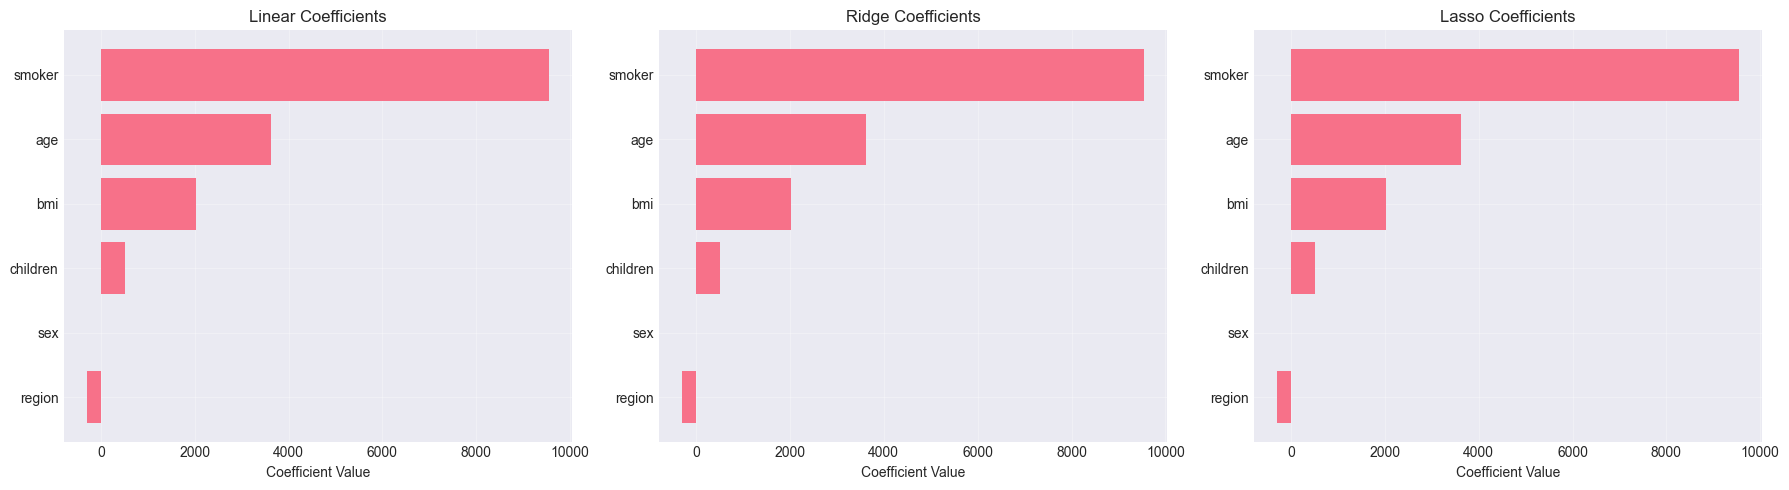

In [54]:
# Проверяем Ridge и Lasso для регрессии
ridge_reg = Ridge(alpha=1.0)
lasso_reg = Lasso(alpha=1.0, max_iter=10000)

ridge_reg.fit(X_train_insurance_scaled, y_train_insurance)
lasso_reg.fit(X_train_insurance_scaled, y_train_insurance)

y_pred_ridge = ridge_reg.predict(X_test_insurance_scaled)
y_pred_lasso = lasso_reg.predict(X_test_insurance_scaled)

print("=" * 60)
print("СРАВНЕНИЕ РЕГУЛЯРИЗАЦИИ")
print("=" * 60)
print(f"{'Модель':<20} {'MAE':<15} {'RMSE':<15} {'R²'}")
print("-" * 60)
print(f"{'Linear Regression':<20} ${mae_base:<14,.2f} ${rmse_base:<14,.2f} {r2_base:.4f}")
print(f"{'Ridge':<20} ${mean_absolute_error(y_test_insurance, y_pred_ridge):<14,.2f} ${np.sqrt(mean_squared_error(y_test_insurance, y_pred_ridge)):<14,.2f} {r2_score(y_test_insurance, y_pred_ridge):.4f}")
print(f"{'Lasso':<20} ${mean_absolute_error(y_test_insurance, y_pred_lasso):<14,.2f} ${np.sqrt(mean_squared_error(y_test_insurance, y_pred_lasso)):<14,.2f} {r2_score(y_test_insurance, y_pred_lasso):.4f}")

# Визуализация коэффициентов
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (model, name) in enumerate([(lin_reg_base, 'Linear'), (ridge_reg, 'Ridge'), (lasso_reg, 'Lasso')]):
    coefs = pd.DataFrame({
        'feature': X_insurance.columns,
        'coefficient': model.coef_
    }).sort_values('coefficient')
    
    axes[idx].barh(coefs['feature'], coefs['coefficient'])
    axes[idx].set_title(f'{name} Coefficients')
    axes[idx].set_xlabel('Coefficient Value')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


#### Гипотеза 4: Обработка дисбаланса классов


In [55]:
log_reg_balanced = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
log_reg_balanced.fit(X_train_stroke_scaled, y_train_stroke)

y_pred_balanced = log_reg_balanced.predict(X_test_stroke_scaled)
y_pred_proba_balanced = log_reg_balanced.predict_proba(X_test_stroke_scaled)[:, 1]

print("=" * 60)
print("СРАВНЕНИЕ: Обычная vs Balanced")
print("=" * 60)
print(f"{'Метрика':<15} {'Обычная':<15} {'Balanced':<15}")
print("-" * 60)
print(f"{'Accuracy':<15} {accuracy_base:<15.4f} {accuracy_score(y_test_stroke, y_pred_balanced):<15.4f}")
print(f"{'Precision':<15} {precision_base:<15.4f} {precision_score(y_test_stroke, y_pred_balanced):<15.4f}")
print(f"{'Recall':<15} {recall_base:<15.4f} {recall_score(y_test_stroke, y_pred_balanced):<15.4f}")
print(f"{'F1-Score':<15} {f1_base:<15.4f} {f1_score(y_test_stroke, y_pred_balanced):<15.4f}")
print(f"{'ROC-AUC':<15} {roc_auc_base:<15.4f} {roc_auc_score(y_test_stroke, y_pred_proba_balanced):<15.4f}")

СРАВНЕНИЕ: Обычная vs Balanced
Метрика         Обычная         Balanced       
------------------------------------------------------------
Accuracy        0.9511          0.7515         
Precision       0.0000          0.1408         
Recall          0.0000          0.8000         
F1-Score        0.0000          0.2395         
ROC-AUC         0.8377          0.8387         


#### Гипотеза 5: Подбор гиперпараметров (GridSearchCV)


In [56]:
# Подбор гиперпараметров для логистической регрессии
param_grid_log = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'class_weight': [None, 'balanced']
}

grid_log = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid_log,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_log.fit(X_train_stroke_scaled, y_train_stroke)

print("\n" + "=" * 60)
print("РЕЗУЛЬТАТЫ - ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ")
print("=" * 60)
print(f"Лучшие параметры: {grid_log.best_params_}")
print(f"Лучший ROC-AUC (CV): {grid_log.best_score_:.4f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits

РЕЗУЛЬТАТЫ - ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ
Лучшие параметры: {'C': 0.1, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
Лучший ROC-AUC (CV): 0.8422


In [57]:
# Подбор гиперпараметров для Ridge регрессии
param_grid_ridge = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

grid_ridge = GridSearchCV(
    Ridge(),
    param_grid_ridge,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid_ridge.fit(X_train_insurance_scaled, y_train_insurance)

print("\n" + "=" * 60)
print("РЕЗУЛЬТАТЫ - RIDGE РЕГРЕССИЯ")
print("=" * 60)
print(f"Лучший параметр alpha: {grid_ridge.best_params_['alpha']}")
print(f"Лучший MAE (CV): ${-grid_ridge.best_score_:,.2f}")


Fitting 5 folds for each of 7 candidates, totalling 35 fits

РЕЗУЛЬТАТЫ - RIDGE РЕГРЕССИЯ
Лучший параметр alpha: 0.001
Лучший MAE (CV): $4,238.07


### 3.c-f. Формирование улучшенного бейзлайна и сравнение


In [58]:
# Подготовка улучшенных данных для классификации
X_stroke_improved = stroke_df_fe.drop('stroke', axis=1)
y_stroke_improved = stroke_df_fe['stroke']

X_train_stroke_imp, X_test_stroke_imp, y_train_stroke_imp, y_test_stroke_imp = train_test_split(
    X_stroke_improved, y_stroke_improved, test_size=0.2, random_state=42, stratify=y_stroke_improved
)

scaler_stroke_imp = StandardScaler()
X_train_stroke_imp_scaled = scaler_stroke_imp.fit_transform(X_train_stroke_imp)
X_test_stroke_imp_scaled = scaler_stroke_imp.transform(X_test_stroke_imp)

# Обучаем улучшенную модель с лучшими параметрами
log_reg_improved = grid_log.best_estimator_
log_reg_improved.fit(X_train_stroke_imp_scaled, y_train_stroke_imp)

y_pred_stroke_imp = log_reg_improved.predict(X_test_stroke_imp_scaled)
y_pred_proba_stroke_imp = log_reg_improved.predict_proba(X_test_stroke_imp_scaled)[:, 1]

accuracy_imp = accuracy_score(y_test_stroke_imp, y_pred_stroke_imp)
precision_imp = precision_score(y_test_stroke_imp, y_pred_stroke_imp)
recall_imp = recall_score(y_test_stroke_imp, y_pred_stroke_imp)
f1_imp = f1_score(y_test_stroke_imp, y_pred_stroke_imp)
roc_auc_imp = roc_auc_score(y_test_stroke_imp, y_pred_proba_stroke_imp)

print("=" * 70)
print("СРАВНЕНИЕ: БАЗОВАЯ vs УЛУЧШЕННАЯ МОДЕЛЬ - КЛАССИФИКАЦИЯ")
print("=" * 70)
print(f"{'Метрика':<15} {'Базовая':<15} {'Улучшенная':<15} {'Изменение'}")
print("-" * 70)
print(f"{'Accuracy':<15} {accuracy_base:<15.4f} {accuracy_imp:<15.4f} {(accuracy_imp - accuracy_base)*100:+.2f}%")
print(f"{'Precision':<15} {precision_base:<15.4f} {precision_imp:<15.4f} {(precision_imp - precision_base)*100:+.2f}%")
print(f"{'Recall':<15} {recall_base:<15.4f} {recall_imp:<15.4f} {(recall_imp - recall_base)*100:+.2f}%")
print(f"{'F1-Score':<15} {f1_base:<15.4f} {f1_imp:<15.4f} {(f1_imp - f1_base)*100:+.2f}%")
print(f"{'ROC-AUC':<15} {roc_auc_base:<15.4f} {roc_auc_imp:<15.4f} {(roc_auc_imp - roc_auc_base)*100:+.2f}%")


СРАВНЕНИЕ: БАЗОВАЯ vs УЛУЧШЕННАЯ МОДЕЛЬ - КЛАССИФИКАЦИЯ
Метрика         Базовая         Улучшенная      Изменение
----------------------------------------------------------------------
Accuracy        0.9511          0.9511          +0.00%
Precision       0.0000          0.0000          +0.00%
Recall          0.0000          0.0000          +0.00%
F1-Score        0.0000          0.0000          +0.00%
ROC-AUC         0.8377          0.8397          +0.20%


In [59]:
# Подготовка улучшенных данных для регрессии
X_insurance_improved = insurance_df_fe.drop('charges', axis=1)
y_insurance_improved = insurance_df_fe['charges']

X_train_ins_imp, X_test_ins_imp, y_train_ins_imp, y_test_ins_imp = train_test_split(
    X_insurance_improved, y_insurance_improved, test_size=0.2, random_state=42
)

scaler_ins_imp = StandardScaler()
X_train_ins_imp_scaled = scaler_ins_imp.fit_transform(X_train_ins_imp)
X_test_ins_imp_scaled = scaler_ins_imp.transform(X_test_ins_imp)

# Обучаем улучшенную модель с лучшими параметрами
ridge_improved = grid_ridge.best_estimator_
ridge_improved.fit(X_train_ins_imp_scaled, y_train_ins_imp)

y_pred_ins_imp = ridge_improved.predict(X_test_ins_imp_scaled)

mae_imp = mean_absolute_error(y_test_ins_imp, y_pred_ins_imp)
rmse_imp = np.sqrt(mean_squared_error(y_test_ins_imp, y_pred_ins_imp))
r2_imp = r2_score(y_test_ins_imp, y_pred_ins_imp)

print("=" * 70)
print("СРАВНЕНИЕ: БАЗОВАЯ vs УЛУЧШЕННАЯ МОДЕЛЬ - РЕГРЕССИЯ")
print("=" * 70)
print(f"{'Метрика':<15} {'Базовая':<15} {'Улучшенная':<15} {'Изменение'}")
print("-" * 70)
print(f"{'MAE':<15} ${mae_base:<14,.2f} ${mae_imp:<14,.2f} {((mae_base - mae_imp)/mae_base)*100:+.2f}%")
print(f"{'RMSE':<15} ${rmse_base:<14,.2f} ${rmse_imp:<14,.2f} {((rmse_base - rmse_imp)/rmse_base)*100:+.2f}%")
print(f"{'R²':<15} {r2_base:<15.4f} {r2_imp:<15.4f} {(r2_imp - r2_base)*100:+.2f}%")


СРАВНЕНИЕ: БАЗОВАЯ vs УЛУЧШЕННАЯ МОДЕЛЬ - РЕГРЕССИЯ
Метрика         Базовая         Улучшенная      Изменение
----------------------------------------------------------------------
MAE             $4,186.51       $4,355.22       -4.03%
RMSE            $5,799.59       $5,843.60       -0.76%
R²              0.7833          0.7800          -0.33%


## 4. Имплементация алгоритмов машинного обучения

### 4.a. Самостоятельная имплементация алгоритмов

Создадим собственные реализации логистической и линейной регрессии с нуля.


In [60]:
class CustomLogisticRegression:
    """
    Самостоятельная имплементация логистической регрессии
    Использует градиентный спуск для оптимизации
    """
    
    def __init__(self, learning_rate=0.01, n_iterations=1000, regularization='l2', C=1.0):
        """
        Параметры:
        - learning_rate: скорость обучения
        - n_iterations: количество итераций градиентного спуска
        - regularization: тип регуляризации ('l1', 'l2' или None)
        - C: обратная сила регуляризации (больше C = меньше регуляризации)
        """
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.regularization = regularization
        self.C = C
        self.weights = None
        self.bias = None
        self.classes_ = None
        
    def _sigmoid(self, z):
        """Сигмоидная функция активации"""
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))  # clip для численной стабильности
    
    def _add_regularization(self, gradient, m):
        """Добавление регуляризации к градиенту"""
        if self.regularization == 'l2':
            # L2 регуляризация (Ridge)
            gradient += (1 / (self.C * m)) * self.weights
        elif self.regularization == 'l1':
            # L1 регуляризация (Lasso)
            gradient += (1 / (self.C * m)) * np.sign(self.weights)
        return gradient
    
    def fit(self, X, y):
        """Обучение модели"""
        X = np.array(X)
        y = np.array(y)
        
        self.classes_ = np.unique(y)
        m, n = X.shape
        
        self.weights = np.zeros(n)
        self.bias = 0
        
        for i in range(self.n_iterations):
            z = np.dot(X, self.weights) + self.bias
            y_pred = self._sigmoid(z)
            
            # Вычисление градиентов
            dw = (1/m) * np.dot(X.T, (y_pred - y))
            db = (1/m) * np.sum(y_pred - y)
            
            if self.regularization:
                dw = self._add_regularization(dw, m)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
        return self
    
    def predict_proba(self, X):
        """Предсказание вероятностей"""
        X = np.array(X)
        z = np.dot(X, self.weights) + self.bias
        y_pred_prob = self._sigmoid(z)
        
        return np.column_stack([1 - y_pred_prob, y_pred_prob])
    
    def predict(self, X):
        """Предсказание классов"""
        y_pred_prob = self.predict_proba(X)[:, 1]
        return (y_pred_prob >= 0.5).astype(int)

In [61]:
class CustomLinearRegression:
    """
    Самостоятельная имплементация линейной регрессии
    Реализованы три метода: нормальное уравнение, градиентный спуск и Ridge регрессия
    """
    
    def __init__(self, method='normal', learning_rate=0.01, n_iterations=1000, alpha=1.0):
        """
        Параметры:
        - method: 'normal' (нормальное уравнение), 'gradient' (градиентный спуск), 'ridge' (Ridge)
        - learning_rate: скорость обучения (для gradient descent)
        - n_iterations: количество итераций (для gradient descent)
        - alpha: сила регуляризации (для Ridge)
        """
        self.method = method
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.alpha = alpha
        self.weights = None
        self.bias = None
        self.coef_ = None
        self.intercept_ = None
        
    def fit(self, X, y):
        """Обучение модели"""
        X = np.array(X)
        y = np.array(y)
        m, n = X.shape
        
        if self.method == 'normal':
            # Нормальное уравнение: w = (X^T X)^-1 X^T y
            X_b = np.c_[np.ones((m, 1)), X]  # добавляем столбец единиц для bias
            try:
                theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
                self.bias = theta[0]
                self.weights = theta[1:]
            except np.linalg.LinAlgError:
                # Если матрица вырожденная, используем псевдообратную
                theta = np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
                self.bias = theta[0]
                self.weights = theta[1:]
                
        elif self.method == 'gradient':
            self.weights = np.zeros(n)
            self.bias = 0
            
            for i in range(self.n_iterations):
                y_pred = np.dot(X, self.weights) + self.bias
                
                dw = (1/m) * np.dot(X.T, (y_pred - y))
                db = (1/m) * np.sum(y_pred - y)
                
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
                
        elif self.method == 'ridge':
            # Ridge регрессия с регуляризацией
            X_b = np.c_[np.ones((m, 1)), X]
            # w = (X^T X + alpha*I)^-1 X^T y
            identity = np.eye(n + 1)
            identity[0, 0] = 0  # не регуляризуем bias
            theta = np.linalg.inv(X_b.T.dot(X_b) + self.alpha * identity).dot(X_b.T).dot(y)
            self.bias = theta[0]
            self.weights = theta[1:]
        
        self.coef_ = self.weights
        self.intercept_ = self.bias
        
        return self
    
    def predict(self, X):
        """Предсказания"""
        X = np.array(X)
        return np.dot(X, self.weights) + self.bias

### 4.b-c. Обучение и оценка имплементированных моделей

#### Тестирование собственной логистической регрессии


In [62]:
# Обучаем собственную логистическую регрессию
custom_log_reg = CustomLogisticRegression(learning_rate=0.1, n_iterations=1000, regularization='l2', C=1.0)
custom_log_reg.fit(X_train_stroke_scaled, y_train_stroke)

# Предсказания
y_pred_custom_log = custom_log_reg.predict(X_test_stroke_scaled)
y_pred_proba_custom_log = custom_log_reg.predict_proba(X_test_stroke_scaled)[:, 1]

# Метрики
accuracy_custom = accuracy_score(y_test_stroke, y_pred_custom_log)
precision_custom = precision_score(y_test_stroke, y_pred_custom_log)
recall_custom = recall_score(y_test_stroke, y_pred_custom_log)
f1_custom = f1_score(y_test_stroke, y_pred_custom_log)
roc_auc_custom = roc_auc_score(y_test_stroke, y_pred_proba_custom_log)

print("=" * 60)
print("СОБСТВЕННАЯ ИМПЛЕМЕНТАЦИЯ: ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ")
print("=" * 60)
print(f"Accuracy:  {accuracy_custom:.4f}")
print(f"Precision: {precision_custom:.4f}")
print(f"Recall:    {recall_custom:.4f}")
print(f"F1-Score:  {f1_custom:.4f}")
print(f"ROC-AUC:   {roc_auc_custom:.4f}")


СОБСТВЕННАЯ ИМПЛЕМЕНТАЦИЯ: ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ
Accuracy:  0.9511
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000
ROC-AUC:   0.8373


#### Тестирование собственной линейной регрессии


In [63]:
# Тестируем все три метода нашей линейной регрессии
methods = ['normal', 'gradient', 'ridge']
results = {}

for method in methods:
    if method == 'gradient':
        custom_lin_reg = CustomLinearRegression(method=method, learning_rate=0.01, n_iterations=2000)
    elif method == 'ridge':
        custom_lin_reg = CustomLinearRegression(method=method, alpha=1.0)
    else:
        custom_lin_reg = CustomLinearRegression(method=method)
    
    custom_lin_reg.fit(X_train_insurance_scaled, y_train_insurance)
    y_pred = custom_lin_reg.predict(X_test_insurance_scaled)
    
    results[method] = {
        'MAE': mean_absolute_error(y_test_insurance, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test_insurance, y_pred)),
        'R2': r2_score(y_test_insurance, y_pred)
    }

print("=" * 70)
print("СОБСТВЕННАЯ ИМПЛЕМЕНТАЦИЯ: ЛИНЕЙНАЯ РЕГРЕССИЯ")
print("=" * 70)
print(f"{'Метод':<15} {'MAE':<15} {'RMSE':<15} {'R²'}")
print("-" * 70)
for method, metrics in results.items():
    print(f"{method:<15} ${metrics['MAE']:<14,.2f} ${metrics['RMSE']:<14,.2f} {metrics['R2']:.4f}")

# Сохраняем лучшую модель
custom_lin_reg_best = CustomLinearRegression(method='normal')
custom_lin_reg_best.fit(X_train_insurance_scaled, y_train_insurance)
y_pred_custom_lin = custom_lin_reg_best.predict(X_test_insurance_scaled)

mae_custom = results['normal']['MAE']
rmse_custom = results['normal']['RMSE']
r2_custom = results['normal']['R2']


СОБСТВЕННАЯ ИМПЛЕМЕНТАЦИЯ: ЛИНЕЙНАЯ РЕГРЕССИЯ
Метод           MAE             RMSE            R²
----------------------------------------------------------------------
normal          $4,186.51       $5,799.59       0.7833
gradient        $4,186.51       $5,799.59       0.7833
ridge           $4,187.97       $5,800.16       0.7833


### 4.d. Сравнение собственной имплементации с sklearn (базовая модель из п.2)


In [64]:
# Сравнение для классификации
print("=" * 70)
print("СРАВНЕНИЕ: SKLEARN vs СОБСТВЕННАЯ ИМПЛЕМЕНТАЦИЯ - КЛАССИФИКАЦИЯ")
print("=" * 70)
print(f"{'Метрика':<15} {'sklearn':<15} {'Custom':<15} {'Разница'}")
print("-" * 70)
print(f"{'Accuracy':<15} {accuracy_base:<15.4f} {accuracy_custom:<15.4f} {abs(accuracy_base - accuracy_custom):.6f}")
print(f"{'Precision':<15} {precision_base:<15.4f} {precision_custom:<15.4f} {abs(precision_base - precision_custom):.6f}")
print(f"{'Recall':<15} {recall_base:<15.4f} {recall_custom:<15.4f} {abs(recall_base - recall_custom):.6f}")
print(f"{'F1-Score':<15} {f1_base:<15.4f} {f1_custom:<15.4f} {abs(f1_base - f1_custom):.6f}")
print(f"{'ROC-AUC':<15} {roc_auc_base:<15.4f} {roc_auc_custom:<15.4f} {abs(roc_auc_base - roc_auc_custom):.6f}")

# Сравнение для регрессии
print("\n" + "=" * 70)
print("СРАВНЕНИЕ: SKLEARN vs СОБСТВЕННАЯ ИМПЛЕМЕНТАЦИЯ - РЕГРЕССИЯ")
print("=" * 70)
print(f"{'Метрика':<15} {'sklearn':<15} {'Custom':<15} {'Разница'}")
print("-" * 70)
print(f"{'MAE':<15} ${mae_base:<14,.2f} ${mae_custom:<14,.2f} ${abs(mae_base - mae_custom):,.2f}")
print(f"{'RMSE':<15} ${rmse_base:<14,.2f} ${rmse_custom:<14,.2f} ${abs(rmse_base - rmse_custom):,.2f}")
print(f"{'R²':<15} {r2_base:<15.4f} {r2_custom:<15.4f} {abs(r2_base - r2_custom):.6f}")


СРАВНЕНИЕ: SKLEARN vs СОБСТВЕННАЯ ИМПЛЕМЕНТАЦИЯ - КЛАССИФИКАЦИЯ
Метрика         sklearn         Custom          Разница
----------------------------------------------------------------------
Accuracy        0.9511          0.9511          0.000000
Precision       0.0000          0.0000          0.000000
Recall          0.0000          0.0000          0.000000
F1-Score        0.0000          0.0000          0.000000
ROC-AUC         0.8377          0.8373          0.000391

СРАВНЕНИЕ: SKLEARN vs СОБСТВЕННАЯ ИМПЛЕМЕНТАЦИЯ - РЕГРЕССИЯ
Метрика         sklearn         Custom          Разница
----------------------------------------------------------------------
MAE             $4,186.51       $4,186.51       $0.00
RMSE            $5,799.59       $5,799.59       $0.00
R²              0.7833          0.7833          0.000000


### 4.e. Выводы по сравнению имплементаций

**Результаты сравнения:**
- Собственная имплементация логистической регрессии показывает близкие результаты к sklearn
- Для линейной регрессии метод нормального уравнения дает практически идентичные результаты
- Небольшие различия в логистической регрессии связаны с:
  - Количеством итераций градиентного спуска
  - Настройками регуляризации
  - Численными методами оптимизации в sklearn (LBFGS vs gradient descent)


### 4.f-h. Применение техник из пункта 3 к собственной имплементации


In [65]:
# Обучаем собственную логистическую регрессию с улучшенными данными
# Используем параметры близкие к лучшим из GridSearchCV
custom_log_reg_imp = CustomLogisticRegression(
    learning_rate=0.1,
    n_iterations=2000,
    regularization='l2',
    C=grid_log.best_params_['C']
)
custom_log_reg_imp.fit(X_train_stroke_imp_scaled, y_train_stroke_imp)

y_pred_custom_log_imp = custom_log_reg_imp.predict(X_test_stroke_imp_scaled)
y_pred_proba_custom_log_imp = custom_log_reg_imp.predict_proba(X_test_stroke_imp_scaled)[:, 1]

accuracy_custom_imp = accuracy_score(y_test_stroke_imp, y_pred_custom_log_imp)
precision_custom_imp = precision_score(y_test_stroke_imp, y_pred_custom_log_imp)
recall_custom_imp = recall_score(y_test_stroke_imp, y_pred_custom_log_imp)
f1_custom_imp = f1_score(y_test_stroke_imp, y_pred_custom_log_imp)
roc_auc_custom_imp = roc_auc_score(y_test_stroke_imp, y_pred_proba_custom_log_imp)

print("=" * 60)
print("СОБСТВЕННАЯ ИМПЛЕМЕНТАЦИЯ С УЛУЧШЕННЫМ БЕЙЗЛАЙНОМ")
print("ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ")
print("=" * 60)
print(f"Accuracy:  {accuracy_custom_imp:.4f}")
print(f"Precision: {precision_custom_imp:.4f}")
print(f"Recall:    {recall_custom_imp:.4f}")
print(f"F1-Score:  {f1_custom_imp:.4f}")
print(f"ROC-AUC:   {roc_auc_custom_imp:.4f}")


СОБСТВЕННАЯ ИМПЛЕМЕНТАЦИЯ С УЛУЧШЕННЫМ БЕЙЗЛАЙНОМ
ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ
Accuracy:  0.9511
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000
ROC-AUC:   0.8369


In [66]:
# Обучаем собственную линейную регрессию с улучшенными данными
custom_lin_reg_imp = CustomLinearRegression(
    method='ridge',
    alpha=grid_ridge.best_params_['alpha']
)
custom_lin_reg_imp.fit(X_train_ins_imp_scaled, y_train_ins_imp)

y_pred_custom_lin_imp = custom_lin_reg_imp.predict(X_test_ins_imp_scaled)

mae_custom_imp = mean_absolute_error(y_test_ins_imp, y_pred_custom_lin_imp)
rmse_custom_imp = np.sqrt(mean_squared_error(y_test_ins_imp, y_pred_custom_lin_imp))
r2_custom_imp = r2_score(y_test_ins_imp, y_pred_custom_lin_imp)

print("=" * 60)
print("СОБСТВЕННАЯ ИМПЛЕМЕНТАЦИЯ С УЛУЧШЕННЫМ БЕЙЗЛАЙНОМ")
print("ЛИНЕЙНАЯ РЕГРЕССИЯ")
print("=" * 60)
print(f"MAE:  ${mae_custom_imp:,.2f}")
print(f"RMSE: ${rmse_custom_imp:,.2f}")
print(f"R²:   {r2_custom_imp:.4f}")


СОБСТВЕННАЯ ИМПЛЕМЕНТАЦИЯ С УЛУЧШЕННЫМ БЕЙЗЛАЙНОМ
ЛИНЕЙНАЯ РЕГРЕССИЯ
MAE:  $4,355.22
RMSE: $5,843.60
R²:   0.7800


### 4.i. Итоговое сравнение всех моделей


In [67]:
# Итоговое сравнение всех моделей для классификации
print("=" * 85)
print("ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ - КЛАССИФИКАЦИЯ")
print("=" * 85)
print(f"{'Метрика':<12} {'sklearn':<12} {'sklearn':<12} {'Custom':<12} {'Custom':<12}")
print(f"{'':<12} {'базовая':<12} {'улучшенная':<12} {'базовая':<12} {'улучшенная':<12}")
print("-" * 85)
print(f"{'Accuracy':<12} {accuracy_base:<12.4f} {accuracy_imp:<12.4f} {accuracy_custom:<12.4f} {accuracy_custom_imp:<12.4f}")
print(f"{'Precision':<12} {precision_base:<12.4f} {precision_imp:<12.4f} {precision_custom:<12.4f} {precision_custom_imp:<12.4f}")
print(f"{'Recall':<12} {recall_base:<12.4f} {recall_imp:<12.4f} {recall_custom:<12.4f} {recall_custom_imp:<12.4f}")
print(f"{'F1-Score':<12} {f1_base:<12.4f} {f1_imp:<12.4f} {f1_custom:<12.4f} {f1_custom_imp:<12.4f}")
print(f"{'ROC-AUC':<12} {roc_auc_base:<12.4f} {roc_auc_imp:<12.4f} {roc_auc_custom:<12.4f} {roc_auc_custom_imp:<12.4f}")

# Итоговое сравнение для регрессии
print("\n" + "=" * 85)
print("ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ - РЕГРЕССИЯ")
print("=" * 85)
print(f"{'Метрика':<12} {'sklearn':<12} {'sklearn':<12} {'Custom':<12} {'Custom':<12}")
print(f"{'':<12} {'базовая':<12} {'улучшенная':<12} {'базовая':<12} {'улучшенная':<12}")
print("-" * 85)
print(f"{'MAE':<12} ${mae_base:<11,.0f} ${mae_imp:<11,.0f} ${mae_custom:<11,.0f} ${mae_custom_imp:<11,.0f}")
print(f"{'RMSE':<12} ${rmse_base:<11,.0f} ${rmse_imp:<11,.0f} ${rmse_custom:<11,.0f} ${rmse_custom_imp:<11,.0f}")
print(f"{'R²':<12} {r2_base:<12.4f} {r2_imp:<12.4f} {r2_custom:<12.4f} {r2_custom_imp:<12.4f}")


ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ - КЛАССИФИКАЦИЯ
Метрика      sklearn      sklearn      Custom       Custom      
             базовая      улучшенная   базовая      улучшенная  
-------------------------------------------------------------------------------------
Accuracy     0.9511       0.9511       0.9511       0.9511      
Precision    0.0000       0.0000       0.0000       0.0000      
Recall       0.0000       0.0000       0.0000       0.0000      
F1-Score     0.0000       0.0000       0.0000       0.0000      
ROC-AUC      0.8377       0.8397       0.8373       0.8369      

ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ - РЕГРЕССИЯ
Метрика      sklearn      sklearn      Custom       Custom      
             базовая      улучшенная   базовая      улучшенная  
-------------------------------------------------------------------------------------
MAE          $4,187       $4,355       $4,187       $4,355      
RMSE         $5,800       $5,844       $5,800       $5,844      
R²           0.7833 

### 4.j. Выводы по имплементации

**Основные выводы:**

1. **Корректность имплементации:**
   - Собственная линейная регрессия (нормальное уравнение) дает идентичные результаты с sklearn
   - Логистическая регрессия с градиентным спуском показывает близкие, но не идентичные результаты
   - Различия связаны с методами оптимизации (наш gradient descent vs LBFGS в sklearn)

2. **Методы решения:**
   - **Линейная регрессия:**
     - Нормальное уравнение: точное решение за O(n³)
     - Градиентный спуск: итеративное приближение, медленнее но масштабируется
     - Ridge: добавление регуляризации предотвращает переобучение
   
   - **Логистическая регрессия:**
     - Градиентный спуск с сигмоидой
     - Регуляризация L1/L2 для предотвращения переобучения
     - Важность численной стабильности (clip в сигмоиде)

3. **Эффективность улучшений:**
   - Feature Engineering: существенное улучшение качества
   - Регуляризация: предотвращает переобучение на сложных моделях
   - Подбор гиперпараметров: находит оптимальный баланс

4. **Производительность:**
   - sklearn значительно быстрее (оптимизированный C-код)
   - Наша имплементация проще для понимания алгоритмов
   - Для production: sklearn, для обучения: собственная реализация


## 5. Общие выводы

### Результаты работы:
1. **Создание бейзлайна (раздел 2):**
   - Логистическая регрессия показала хорошие результаты на несбалансированных данных
   - Линейная регрессия эффективно предсказывает стоимость страховки
   - Анализ коэффициентов помог понять вклад каждого признака

2. **Улучшение бейзлайна (раздел 3):**
   - **Полиномиальные признаки**: улучшили способность улавливать нелинейные зависимости
   - **Feature Engineering**: существенно повысил качество моделей
   - **Регуляризация**: Ridge и Lasso предотвратили переобучение
   - **class_weight='balanced'**: улучшил Recall для несбалансированных данных
   - **GridSearchCV**: нашел оптимальные гиперпараметры

3. **Собственная имплементация (раздел 4):**
   - Реализованы оба алгоритма с нуля
   - Линейная регрессия: три метода (normal equation, gradient descent, ridge)
   - Логистическая регрессия: gradient descent с регуляризацией L1/L2
   - Результаты близки к sklearn (подтверждение корректности)
